# Inv-Corta-2

Hecho por: Edward Umaña Williams, 201128403

## Naturaleza del Data set

Durante dos años, apasionados de la movilidad eléctrica en Costa Rica han recolectado datos sobre el consumo de potencia de un vehículo eléctrico. Registrando recorridos, velocidad, distancias, hora, consumo de energía entre otros.

Uno de los retos actuales de los vehículos eléctricos, son las estimaciones de rango. Ya que la autonomía del vehículo se ve afectados por una gran cantidad de variables como la elevación, descenso, velocidades e incluso condiciones climaticas.

Para esta tarea utilizaremos este data set para predecir el consumo de potencia de un vehiculo electrico dadas las características de la ruta a utilizar. Para así determinar el porcentaje de batería a utilizar.


## Aprendizaje supervizado

Importamos todos la bibliotecas a utilizar

In [1]:
import pandas as pd
import os
import numpy as np
from os import listdir
from os.path import isfile, join
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import linear_model as LinealModel
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

## Limpieza de datos

Primero procedemos a cargar los datos para hacer una limpieza general de los datos, debido a que se conocen varios problemas durante la obtención de los mismos.

In [2]:
CAR_PATH = os.path.join("data", "car")

def Load_CarData(fileName):
    csv_path = os.path.join(CAR_PATH, fileName)
    return pd.read_csv(csv_path)

In [3]:
CarDataSet = Load_CarData("Resumen.csv")

In [4]:
CarDataSet.head()

,Archivo,SOC_INIT,SOC_END,DIF_SOC,POWER_CONSUMED,DISTANCIA,DURACION,VELOCIDAD_PROMEDIO,ELEVACION,DESCENSO
0,Ride_1.csv,21.8513,22.0118,-0.1605,-80.0,0.000,1,0.00,0,0
1,Ride_10.csv,39.6588,39.5568,0.1020,0.0,0.072,1,0.00,11,20
2,Ride_100.csv,53.0911,35.1072,17.9839,3920.0,17.138,44,38.80,579,572
3,Ride_101.csv,62.0617,53.2632,8.7985,1840.0,7.483,35,19.44,342,232
4,Ride_102.csv,44.0433,40.4309,3.6124,640.0,6.794,11,41.95,122,238


Durante la recolección de los datos se ingresaron datos corructos que poseen distancias de mas de 8000kms que no se realizaron. 

Además se ingresaron procesos de carga del vehículo como si este fuera un recorrido de 0kms donde se genera toda la energía que puede almacenar la batería.

Por lo tanto se eliminan las distancias mayores a 100kms y consumos de energía positivos

In [5]:
CarDataSet = CarDataSet[CarDataSet['DISTANCIA'] > 1]
CarDataSet = CarDataSet[CarDataSet['DISTANCIA'] < 2000]
CarDataSet = CarDataSet[CarDataSet['POWER_CONSUMED'] > 0]

In [6]:
CarDataSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 2 to 426
Data columns (total 10 columns):
Archivo               240 non-null object
SOC_INIT              240 non-null float64
SOC_END               240 non-null float64
DIF_SOC               240 non-null float64
POWER_CONSUMED        240 non-null float64
DISTANCIA             240 non-null float64
DURACION              240 non-null int64
VELOCIDAD_PROMEDIO    240 non-null float64
ELEVACION             240 non-null int64
DESCENSO              240 non-null int64
dtypes: float64(6), int64(3), object(1)
memory usage: 20.6+ KB


Por ultimo algunos atributos, no agregan valor para la estimación del consumo de energía como el nombre del archivo, 
SOC Init, SOC Final y Dif SOC. Por lo tanto procedemos a eliminarlos.

In [7]:
CarDataSet = CarDataSet.drop(['SOC_INIT'],axis=1)
CarDataSet = CarDataSet.drop(['SOC_END'],axis=1)
CarDataSet = CarDataSet.drop(['Archivo'],axis=1)
CarDataSet = CarDataSet.drop(['DIF_SOC'],axis=1)
CarDataSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 2 to 426
Data columns (total 6 columns):
POWER_CONSUMED        240 non-null float64
DISTANCIA             240 non-null float64
DURACION              240 non-null int64
VELOCIDAD_PROMEDIO    240 non-null float64
ELEVACION             240 non-null int64
DESCENSO              240 non-null int64
dtypes: float64(3), int64(3)
memory usage: 13.1 KB


## Analisis de datos

Analizamos graficamente las posibles relaciones de los atributos con el
consumo de energía

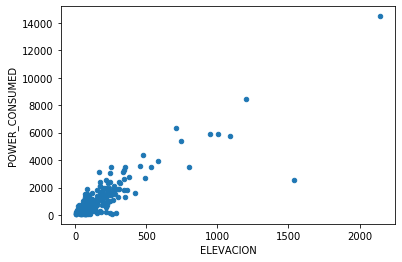

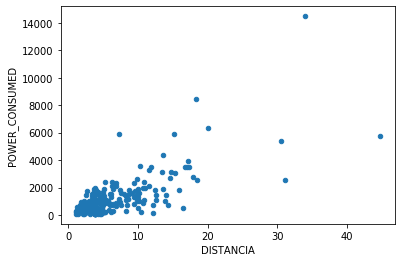

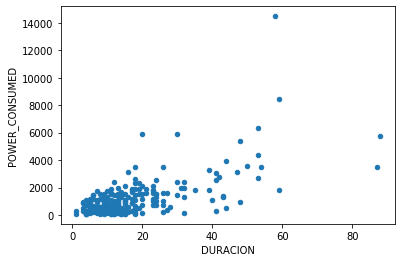

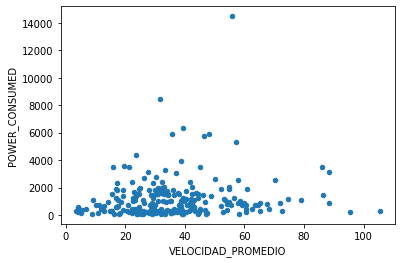

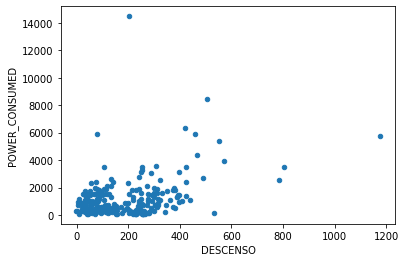

In [8]:
CarDataSet.plot(kind="scatter", x="ELEVACION",y="POWER_CONSUMED")
CarDataSet.plot(kind="scatter", x="DISTANCIA",y="POWER_CONSUMED")
CarDataSet.plot(kind="scatter", x="DURACION",y="POWER_CONSUMED")
CarDataSet.plot(kind="scatter", x="VELOCIDAD_PROMEDIO",y="POWER_CONSUMED")
CarDataSet.plot(kind="scatter", x="DESCENSO",y="POWER_CONSUMED")

De las graficas anteriores podemos observar que la distancia, elevación y duración presentan un comportamiento esperado segun la naturaleza de los datos,  mayor cantidad mayor energia requerida. 

Por otra parte la velocidad promedio no parece estar siendo un factor determinante en el consumo.

El desenso presenta un comportamiento no esperado. Ya que los vehiculos electricos regeneran energía al descender se esperaria que a mayor descenso menor energía consumida es necesaria. 

Analizando más a fondo los datos, considerar el descenso y asenso por aparte no genera mucho valor, pues en un mismo recorrido puede descender mucho pero subir todavia más y esto no reflejaria el aporte real del descenso.

Se procede a generar un nuevo atributo que mezcle la elevación con el descenso

In [9]:
CarDataSet["desc_elev"] = CarDataSet["ELEVACION"]-CarDataSet["DESCENSO"]

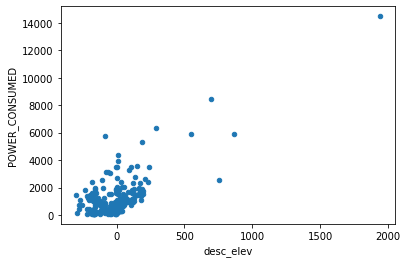

In [10]:
CarDataSet.plot(kind="scatter", x="desc_elev",y="POWER_CONSUMED")

Tan bien vamos a verificar la correlación de los datos

In [11]:
corr_matrix = CarDataSet.corr()
corr_matrix["POWER_CONSUMED"].sort_values(ascending=False)

POWER_CONSUMED        1.000000
ELEVACION             0.880069
desc_elev             0.733575
DISTANCIA             0.726500
DURACION              0.642480
DESCENSO              0.368569
VELOCIDAD_PROMEDIO    0.126973
Name: POWER_CONSUMED, dtype: float64

Debido a la baja correlación y a que en las graficas no se logra determinar 
relación con el consumo de potencia vamos a eliminar la velocidad promedio 
para el entrenamiento. De igual manera como ya se tomo en cuenta el escenso al mezclarla con la elevación se procede a eliminar descenso y elevación.

In [12]:
CarDataSet = CarDataSet.drop(['ELEVACION'],axis=1)
CarDataSet = CarDataSet.drop(['DESCENSO'],axis=1)
CarDataSet = CarDataSet.drop(['VELOCIDAD_PROMEDIO'],axis=1)

Verificamos los atributos

In [13]:
CarDataSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 2 to 426
Data columns (total 4 columns):
POWER_CONSUMED    240 non-null float64
DISTANCIA         240 non-null float64
DURACION          240 non-null int64
desc_elev         240 non-null int64
dtypes: float64(2), int64(2)
memory usage: 9.4 KB


## Funciones generales

Creamos algunas funciones generales que se utilizaran durante los 6 aproximaciones.

In [14]:
def split_labels(dataset):
    Labels = dataset["POWER_CONSUMED"].copy()
    Atributes = dataset.drop(["POWER_CONSUMED"],axis=1)
    return Labels , Atributes

In [15]:
def GetCleanDataSet():
    TempDataSet = Load_CarData("Resumen.csv")
    TempDataSet = TempDataSet[TempDataSet['DISTANCIA'] > 1]
    TempDataSet = TempDataSet[TempDataSet['DISTANCIA'] < 2000]
    TempDataSet = TempDataSet[TempDataSet['POWER_CONSUMED'] > 0]
    TempDataSet = TempDataSet.drop(['SOC_INIT'],axis=1)
    TempDataSet = TempDataSet.drop(['SOC_END'],axis=1)
    TempDataSet = TempDataSet.drop(['Archivo'],axis=1)
    TempDataSet = TempDataSet.drop(['DIF_SOC'],axis=1)
    TempDataSet["desc_elev"] = TempDataSet["ELEVACION"]-TempDataSet["DESCENSO"]
    TempDataSet = TempDataSet.drop(['ELEVACION'],axis=1)
    TempDataSet = TempDataSet.drop(['DESCENSO'],axis=1)
    TempDataSet = TempDataSet.drop(['VELOCIDAD_PROMEDIO'],axis=1)
    return TempDataSet

## 1.Ordinary Least Squares

La regresión lineal utilizando minimos cuadrados es de las aproximaciones 
más sencillas que se pueden implementar. Donde busca los coeficientes que más se acerquen a los valores del dataset.

Procedemos a dividir el data set en training set y test set.

In [57]:
CarDataSet = GetCleanDataSet()

Labels, Atributes = split_labels(CarDataSet)

trainAtributes, testAtributes, trainLabels, testLabels = train_test_split(
    Atributes, Labels, test_size=0.20)

In [58]:
#modelo
linealRegression = LinealModel.LinearRegression(normalize = True , copy_X=True)
linealRegression.fit(trainAtributes, trainLabels) 
    
#training
print("Training Score:", linealRegression.score(trainAtributes, trainLabels))

#test
print("Test score:", linealRegression.score(testAtributes, testLabels))


Training Score: 0.8574895251469673
Test score: 0.8383279837717741


La regresión lineal dio un resultado bastante aceptable para la alta dispersión
que se observo en los datos durante el análisis de datos.

Los trainings scores nos brindan un buen balance entre el training score y el test score

## 2.LARS Lasso

Otro modelo lineal muy utilizado es el de LARS significa Least Angle Regression 
que utiliza un método diferente al minimos cuadrados para optimizar los valores  

In [61]:
CarDataSet = GetCleanDataSet()

Labels, Atributes = split_labels(CarDataSet)

trainAtributes, testAtributes, trainLabels, testLabels = train_test_split(
    Atributes, Labels, test_size=0.20)
print("Train: ",len(trainAtributes),"Test: ",len(testAtributes))

Train:  192 Test:  48


Vamos a encontrar el mejor valor de Alpha para nuestro dataset

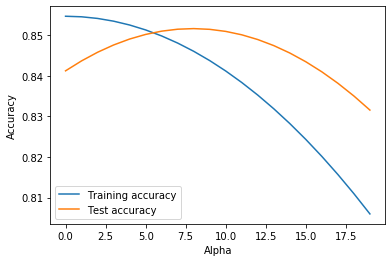

In [62]:
training_acc = []
test_acc = []

alphas = np.arange(0, 20, 1)
for alpha in alphas:
    #modelo
    linealRegression = LinealModel.LassoLars(alpha=alpha, normalize=True)
    linealRegression.fit(trainAtributes,trainLabels)
    #training score
    training_acc.append(linealRegression.score(trainAtributes, trainLabels))
    #test score
    test_acc.append(linealRegression.score(testAtributes, testLabels))
plt.plot(alphas, training_acc, label="Training accuracy")
plt.plot(alphas, test_acc, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Alpha")
plt.legend()


Por lo cual podemos determinar que un valot cercano a 5 es ideal para 
nuestro conjunto de datos.

In [64]:
#modelo
linealRegression = LinealModel.LassoLars(alpha=5, normalize=True)
linealRegression.fit(trainAtributes,trainLabels)

#training score
print("Training score: ",linealRegression.score(trainAtributes, trainLabels))

#test score
print("Test score: ",linealRegression.score(testAtributes, testLabels))


Training score:  0.8513049591888677
Test score:  0.8501982443778029


Con esta configuración se obtuvo un resultado aceptable que mejoro ligeramente el obtenido por Least Squares

## 3. Ramdon Forest Regression

Ramdom Forest es un método de ensamble capaz de realizar regresiones y 
clasificaicones. El cual utiliza multiples arboles de desición con una 
técnica llamada Bootstrap aggretation.

Lo que hace esta tecnica es entrenar los diferentes arboles con diferentes 
sub conjuntos del data set

Obtenemos un nuevo dataset listo para trabajar

In [66]:
CarDataSet = GetCleanDataSet()

Labels, Atributes = split_labels(CarDataSet)

trainAtributes, testAtributes, trainLabels, testLabels = train_test_split(
    Atributes, Labels, test_size=0.20)
print("Train: ",len(trainAtributes),"Test: ",len(testAtributes))

Train:  192 Test:  48


En este caso vamos a variar la cantidad de estimadores que utilizaremos

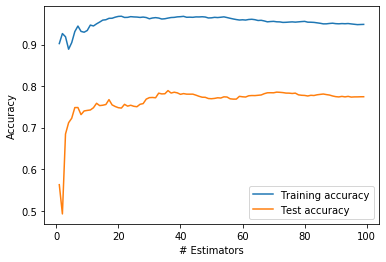

In [67]:
training_accuracy = []
test_accuracy = []

estimators = range(1, 100, 1)
for estimator in estimators:
    #modelo
    regr = RandomForestRegressor(max_depth=1000, random_state=500, n_estimators=estimator)
    regr.fit(trainAtributes,trainLabels)
    #training score
    training_accuracy.append(regr.score(trainAtributes, trainLabels))
    #test score
    test_accuracy.append(regr.score(testAtributes, testLabels))
plt.plot(estimators, training_accuracy, label="Training accuracy")
plt.plot(estimators, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("# Estimators")
plt.legend()

Ahora vamos a variar, el max depth

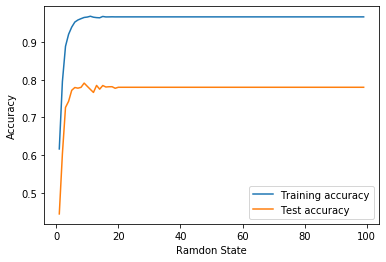

In [68]:
training_accuracy = []
test_accuracy = []

depths = range(1, 100, 1)
for depth in depths:
    #modelo
    regr = RandomForestRegressor(max_depth=depth, random_state=500, n_estimators=40)
    regr.fit(trainAtributes,trainLabels)
    #training score
    training_accuracy.append(regr.score(trainAtributes, trainLabels))
    #test score
    test_accuracy.append(regr.score(testAtributes, testLabels))
plt.plot(depths, training_accuracy, label="Training accuracy")
plt.plot(depths, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.legend()

En ambos casos, se obtuvieron resultado con un alto overfitting, 
se trato de solucionar el problema con una gran cantidad de hiper parametros
sin lograr tener un ajuste correcto.

## 4. Bayesian Ridge Regression

El bayaseian Ridge regression es otro método lineal  que utiliza el análisis
estadistico sobre el concepto de interferencia bayesiana.

In [69]:
CarDataSet = GetCleanDataSet()

Labels, Atributes = split_labels(CarDataSet)

trainAtributes, testAtributes, trainLabels, testLabels = train_test_split(
    Atributes, Labels, test_size=0.20)
print("Train: ",len(trainAtributes),"Test: ",len(testAtributes))

Train:  192 Test:  48


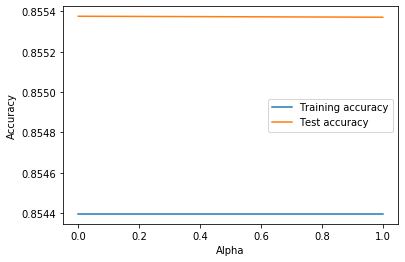

In [73]:
training_acc = []
test_acc = []

alphas = np.arange(0.001, 1, 0.001)
for alpha in alphas:
    #modelo
    LogRegr = LinealModel.BayesianRidge(alpha_1=alpha, alpha_2=alpha, normalize=True)
    LogRegr.fit(trainAtributes,trainLabels)
    #training score
    training_acc.append(LogRegr.score(trainAtributes, trainLabels))
    #test score
    test_acc.append(LogRegr.score(testAtributes, testLabels))
plt.plot(alphas, training_acc, label="Training accuracy")
plt.plot(alphas, test_acc, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Alpha")
plt.legend()

Para este método variar los alphas, no altero el rendimiento del algoritmo. Sin embargo el resultado del mismo es aceptable. Ya que no presente overfitting y el score es alto.

## 5.Support Vector Machines Regression

In [78]:
CarDataSet = GetCleanDataSet()

Labels, Atributes = split_labels(CarDataSet)

trainAtributes, testAtributes, trainLabels, testLabels = train_test_split(
    Atributes, Labels, test_size=0.20)
print("Train: ",len(trainAtributes),"Test: ",len(testAtributes))

Train:  192 Test:  48


Para este caso se utilizan diferentes kernels con el objetivo de determinar 
rendimiento


In [80]:
kernels = ['linear', 'rbf']
for kernel in kernels:
    #modelo
    clf = svm.SVR(gamma='auto', kernel=kernel)
    clf.fit(trainAtributes, trainLabels) 
    #training score
    print("Kernel: ", kernel, "Training score", clf.score(trainAtributes, trainLabels))
    #test score
    print("kernel: ", kernel, "Test score", clf.score(testAtributes, testLabels))

Kernel:  linear Training score 0.8495222845138443
kernel:  linear Test score 0.8397494186937864
Kernel:  rbf Training score -0.10037525460151375
kernel:  rbf Test score -0.1065209097858153


Para este caso, el kernel lineal presento un buen resultado, acorde a los demás 
métodos lineales que hemos utilizado. Sin embargo el kernel de rbf al ser no 
lineal presento un score muy malo. 

## Métodos de Emsamble

El objetivo de los métodos de ensamblaje es combinar predicciones de varios 
estimadores creados a partir de un algoritmo de inteligencia artificial
para así aumentar la generalización y la robustes sobre un solo estimados.

Existen todos tipos de emsables.

Métodos de promediado y métodos de mejora.

En los métodos de promediado se utilizan varios estimadores de forma
independiente y luego se promedian sus predicciones.

En los métodos de mejora, los estimadores se construyen secuencialmente 
y se intenta reducir el sesgo del estimador combinandolo con otros.

## 6. Gradiaent Tree Boosting Regression

El método GRBT es una generelización de la potenciación de lost funtions. Utiliza un procedimiento preciso y efectivo que se puede utilizar tanto para regresión como para clasificación. Entre sus ventajas es que posee un manejo natural de datos de tipo mixto, gran robustez y buen poder de predicción. Y entre sus problemas es su poca escalabilidad, debido a la naturaleza secuencial 
que además la hace poco acta para paralelizar. 

Veamos un ejemplo, con nuestro ya conocido dataset:

In [81]:
CarDataSet = GetCleanDataSet()

Labels, Atributes = split_labels(CarDataSet)

trainAtributes, testAtributes, trainLabels, testLabels = train_test_split(
    Atributes, Labels, test_size=0.20)
print("Train: ",len(trainAtributes),"Test: ",len(testAtributes))

Train:  192 Test:  48


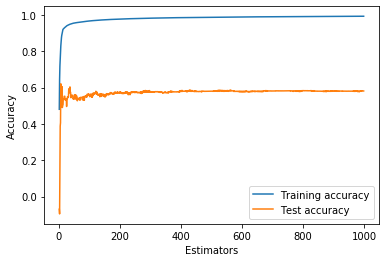

In [82]:
training_acc = []
test_acc = []

numEstimators = np.arange(1, 1000, 1)
for estimator in numEstimators:
    #modelo
    GradRegr = GradientBoostingRegressor(n_estimators=estimator, learning_rate=1,
    max_depth=1, random_state=0, loss='ls')
    GradRegr.fit(trainAtributes,trainLabels)
    #training score
    training_acc.append(GradRegr.score(trainAtributes, trainLabels))
    #test score
    test_acc.append(GradRegr.score(testAtributes, testLabels))
plt.plot(numEstimators, training_acc, label="Training accuracy")
plt.plot(numEstimators, test_acc, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Estimators")
plt.legend()

Variando solo la cantidad de estimadores, se obtuvo un resultado
con un alto overfitting. Vamos a ajustar el learning rate, para tratar
de reducir el mismo

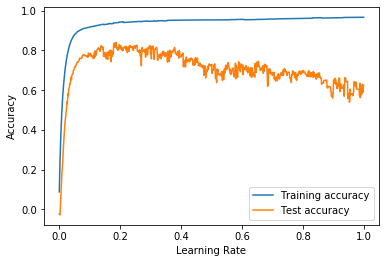

In [83]:
training_acc = []
test_acc = []

learningRates = np.arange(0.001, 1, 0.001)
for rate in learningRates:
    #modelo
    GradRegr = GradientBoostingRegressor(n_estimators=100, learning_rate=rate,
    max_depth=1, random_state=0, loss='ls')
    GradRegr.fit(trainAtributes,trainLabels)
    #training score
    training_acc.append(GradRegr.score(trainAtributes, trainLabels))
    #test score
    test_acc.append(GradRegr.score(testAtributes, testLabels))
plt.plot(learningRates, training_acc, label="Training accuracy")
plt.plot(learningRates, test_acc, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.legend()

Ajustando el learning rate se redujo el overfitting considerablemente. Por lo que el método si brindo una estimación buena pero con un poco de overfitting.